In [61]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import notebookfns as n
from scipy.integrate import odeint

In [2]:
fname = '../exp_l96/Lorenz96_2024_12_09_12_10_01_056169'
modelname = fname + '_model.pkl'
errorname = fname + '_error.csv'

In [225]:
with open(modelname, 'rb') as f:
    params = pickle.load(f, encoding='latin1')
W, b = n.load_weights_koopman(modelname, len(params['widths'])-1, len(params['widths_omega_real'])-1, params['num_real'], params['num_complex_pairs'])

In [27]:
X = np.loadtxt('../data/%s_val_x.csv' % params['data_name'],delimiter=',')
max_shifts_to_stack = n.num_shifts_in_stack(params)
X_stacked, num_traj_val = n.stack_data(X, max_shifts_to_stack, params['len_time'])
X0 = np.squeeze(X_stacked[0,:,:])
print(X_stacked.shape, X0.shape)

(101, 5000, 4) (5000, 4)


In [171]:
y = n.PredictKoopmanNetOmegas(X0, W, b, params['delta_t'], 5001, params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])
y = np.array(y)
print(y.shape)

(5000, 5001, 4)


In [62]:
def gen_trajs(initial, t_eval, F):
    num_trajs, N = initial.shape
    odefunc = lambda x, t : (np.roll(x, -1) - np.roll(x, 2)) * np.roll(x, 1) - x + F
    trajs = np.zeros((num_trajs, len(t_eval), N))
    for i in range(num_trajs):
        if i%1000 == 0:
            print(i)
        trajs[i,:,:] = odeint(odefunc, initial[i,:], t_eval)
    return trajs

In [157]:
t_eval = np.arange(0, 5.0005, params['delta_t'])
F = 0
y_true = gen_trajs(X0, t_eval, F)

0
1000
2000
3000
4000


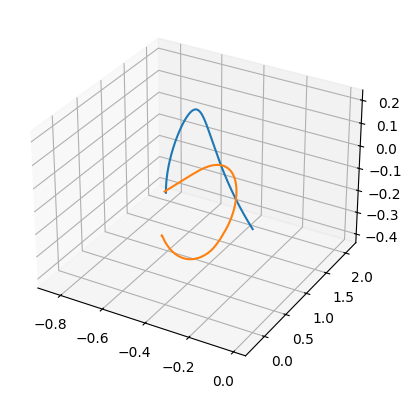

In [266]:
for k in range(20):
    i = np.random.randint(y.shape[0])
    j = np.random.randint(y.shape[-1])
    plt.plot(y[i,:,j])
    plt.plot(y_true[i,:,j])
    plt.savefig('./Lorenz96Figures/ex_traj_'+str(k)+'.png')
    plt.close()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_true[i, :, 0], y_true[i, :, 1], y_true[i, :, 2])
ax.plot(y[i, :, 0], y[i, :, 1], y[i, :, 2])
plt.show()